## Sagnac Frequency - Backscatter Correction - RZ FSR

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv, DatetimeIndex
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d


In [2]:
from functions.read_sds import __read_sds
from functions.read_yaml import __readYaml
from functions.load_furt_stream import __load_furt_stream
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data
from functions.conversion_to_tilt import __conversion_to_tilt
from functions.load_water_level import __load_water_level
from functions.load_beam_wander_data import __load_beam_wander_data
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [4]:
config = {}

config['ring'] = "Z"

config['delta'] = 60

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"


# with GPS reference and new settings
config['tbeg'] = UTCDateTime("2024-08-29 12:00")
config['tend'] = UTCDateTime("2024-09-03 00:00")
config['flim1'], config['flim2'] = 553.568, 553.580


# path to Sagnac data
# config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"manuscripts/manuscript_romy_drifts/data/"

# config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"manuscripts/manuscript_romy_drifts/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }


### Load Backscatter Data

In [5]:
bs = read_pickle(config['path_to_data']+"bs_fsr.pkl")

# update time seconds
bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - config['tbeg'])

bs = bs[(bs.time1 >= config['tbeg']) & (bs.time2 <= config['tend'])]


<Figure size 1500x500 with 0 Axes>

(553.568, 553.58)

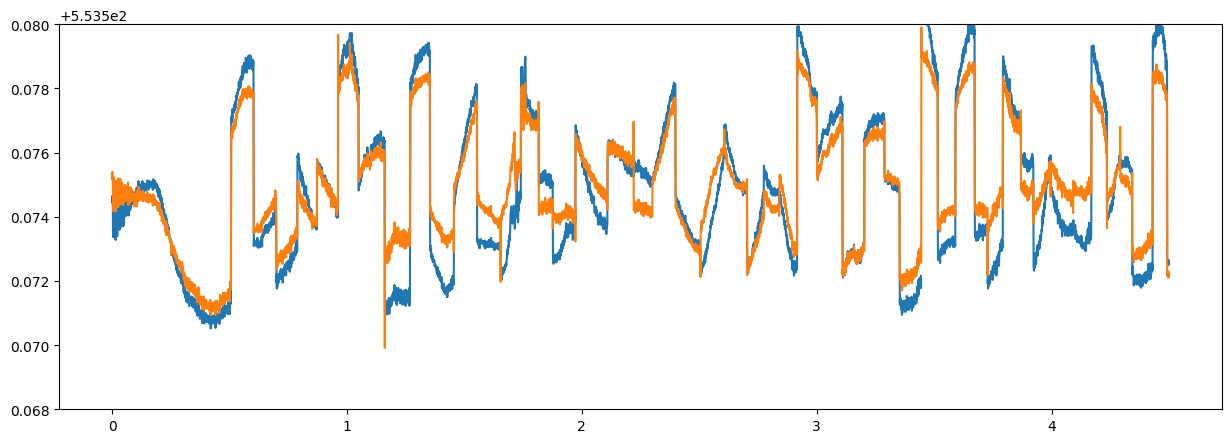

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.plot(bs.time_sec/86400, bs.fj_bs)

# plt.plot(bs.time_sec/86400, gaussian_filter1d(bs.fj_bs, 2))

plt.ylim(config['flim1'], config['flim2'])

### Load WROMY Data

In [7]:
# ws = Stream()
# ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
# ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
# ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

# ws = ws.merge();

# ws

### Load PROMY Data

In [8]:
ps = Stream()
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps3 = ps.merge();

ps

5 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-02T23:59:59.000000Z | 1.0 Hz, 388800 samples
BW.PROMY.03.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-02T23:59:59.000000Z | 1.0 Hz, 388800 samples
BW.PROMY.05.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-02T23:59:59.000000Z | 1.0 Hz, 388800 samples
BW.PROMY.07.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-02T23:59:59.000000Z | 1.0 Hz, 388800 samples
BW.PROMY.09.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-02T23:59:59.000000Z | 1.0 Hz, 388800 samples

In [9]:
# ws9 = __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])
# ps9 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])
# plt.plot(ws9[0].data)
# plt.plot(ps9[0].data)
# plt.ylim(22, 26)

### Load Rain Data

In [10]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [11]:
furt = __load_furt_stream(config['tbeg']-60, config['tend']+60, path_to_archive=bay_path+'gif_online/FURT/WETTER/')

/home/brotzer/notebooks/SagnacFrequency/functions/load_furt_stream.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="ignore")


In [12]:
rain = furt.select(channel="LAR")

rain = rain.trim(config['tbeg'], config['tend'])

for tr in rain:
    tr.data = np.nan_to_num(tr.data, 0)

# smoothed precipitation
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)

# cumulative rain
rain_cumsum = np.nancumsum(rain[0].data)

### Load Tilt Data

  -> converted data of ROMYT


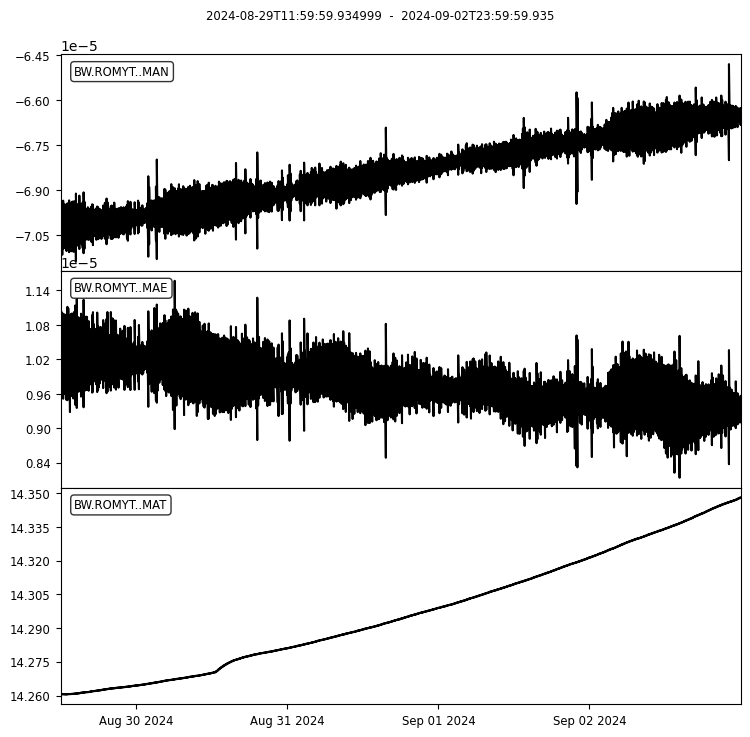

In [13]:
path_to_tilt = archive_path+"romy_archive/"

tromy0 = Stream()
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

# tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.trim(config['tbeg'], config['tend']);

tromy0 = tromy0.merge();

tromy0.plot(equal_scale=False);

In [14]:
NN = int(20*tromy0.select(channel="*N")[0].stats.sampling_rate)

tromyN_smooth = __smooth(__reduce(tromy0.select(channel="*N")[0].data, 100), NN)
tromyE_smooth = __smooth(__reduce(tromy0.select(channel="*E")[0].data, 100), NN)

### Load Water Level Data

In [15]:
try:
    pegel = __load_water_level(config['tbeg'], config['tend'], path_to_data=lamont_path+"Pegel/")

    # remove error measurements with nan
    pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

    pegel
except Exception as e:
    print(e)
    print(" -> pegel not loaded")


,index,day,time,pegel,temperatur,times_utc,times_utc_sec
1440,1440,29.08.2024,12:00:00,3.620850,8.9785,2024-08-29T12:00:00.000000Z,0.0
1441,1441,29.08.2024,12:00:30,3.619125,8.9765,2024-08-29T12:00:30.000000Z,30.0
1442,1442,29.08.2024,12:01:00,3.620250,8.9765,2024-08-29T12:01:00.000000Z,60.0
1443,1443,29.08.2024,12:01:30,3.621150,8.9785,2024-08-29T12:01:30.000000Z,90.0
1444,1444,29.08.2024,12:02:00,3.618975,8.9765,2024-08-29T12:02:00.000000Z,120.0
...,...,...,...,...,...,...,...
14395,2875,02.09.2024,23:57:30,3.581175,8.9545,2024-09-02T23:57:30.000000Z,388650.0
14396,2876,02.09.2024,23:58:00,3.581325,8.9545,2024-09-02T23:58:00.000000Z,388680.0
14397,2877,02.09.2024,23:58:30,3.583725,8.9565,2024-09-02T23:58:30.000000Z,388710.0
14398,2878,02.09.2024,23:59:00,3.581325,8.9550,2024-09-02T23:59:00.000000Z,388740.0


### Load LXX Data

In [16]:
# load log data
lxx = __load_lxx(config['tbeg'], config['tend'], archive_path)

# make intervals
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Load Beam Wander Data

In [17]:
df01 = read_pickle(config['path_to_data']+"ids01_fsr.pkl")

df03 = read_pickle(config['path_to_data']+"ids03_fsr.pkl")

df05 = read_pickle(config['path_to_data']+"ids05_fsr.pkl")

In [18]:
def __process(df0):

    # cut to time period
    df0 = df0[(df0.time_utc >= config['tbeg']) & (df0.time_utc <= config['tend'])]

    df0.loc[:, 'y_um_rel'] = __reduce(df0.y_um_rel, 3)
    df0.loc[:, 'x_um_rel'] = __reduce(df0.x_um_rel, 3)

    df0.reset_index(drop=True, inplace=True)
    return df0

df01 = __process(df01)
df03 = __process(df03)
df05 = __process(df05)


### Load Infrasound FFBI

In [19]:
ffbi = Stream()
ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDF", config['tbeg'], config['tend'])
ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

In [20]:
ffbi_bdf_smooth1 = __smooth(ffbi.select(channel="*F")[0].data, int(60*ffbi.select(channel="*F")[0].stats.sampling_rate))
ffbi_bdf_smooth2 = __smooth(ffbi.select(channel="*F")[0].data, int(3600*ffbi.select(channel="*F")[0].stats.sampling_rate))

### Load FSR Data

In [21]:
fsr = read_pickle(config['path_to_data']+"romy_fsr_ex2.pkl")

fsr = fsr[(fsr.time_utc >= config['tbeg']) & (fsr.time_utc <= config['tend'])]

# fsr['disp_rel'] = __reduce(fsr.disp_rel, 10)

fsr['time_sec'] = [_t - config['tbeg'] for _t in fsr.time_utc]


In [22]:
fsr

,datetime,x_hz,y_dbm,time_sec,time_utc,x_mod,y_mod,disp,x_mod_avg,x_mod_std,disp_avg,disp_std,x_mod_rel,x_mod_avg_rel,disp_avg_rel
3586,2024-08-29 12:00:00.739891,1.072995e+08,-81.388664,0.739891,2024-08-29T12:00:00.739891Z,1.072995e+08,-81.388664,33.550956,NaN,NaN,NaN,NaN,-0.73,NaN,NaN
3587,2024-08-29 12:00:01.743856,1.072995e+08,-77.397118,1.743856,2024-08-29T12:00:01.743856Z,1.072995e+08,-77.397118,33.550956,NaN,NaN,NaN,NaN,-0.73,NaN,NaN
3588,2024-08-29 12:00:02.746753,1.072995e+08,-77.397118,2.746753,2024-08-29T12:00:02.746753Z,1.072995e+08,-77.397118,33.550956,NaN,NaN,NaN,NaN,-0.73,NaN,NaN
3589,2024-08-29 12:00:03.752029,1.072995e+08,-77.043510,3.752029,2024-08-29T12:00:03.752029Z,1.072995e+08,-77.043510,33.550956,NaN,NaN,NaN,NaN,-0.73,NaN,NaN
3590,2024-08-29 12:00:04.756119,1.072995e+08,-77.043510,4.756119,2024-08-29T12:00:04.756119Z,1.072995e+08,-77.043510,33.550956,NaN,NaN,NaN,NaN,-0.73,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390826,2024-09-02 23:59:55.966039,1.072994e+08,-81.659592,388795.966039,2024-09-02T23:59:55.966039Z,1.072994e+08,-81.659592,33.550988,NaN,NaN,NaN,NaN,-104.20,NaN,NaN
390827,2024-09-02 23:59:56.970073,1.072994e+08,-81.659592,388796.970073,2024-09-02T23:59:56.970073Z,1.072994e+08,-81.659592,33.550988,NaN,NaN,NaN,NaN,-104.20,NaN,NaN
390828,2024-09-02 23:59:57.974047,1.072994e+08,-76.056847,388797.974047,2024-09-02T23:59:57.974047Z,1.072994e+08,-76.056847,33.550988,NaN,NaN,NaN,NaN,-104.20,NaN,NaN
390829,2024-09-02 23:59:58.978156,1.072994e+08,-76.056847,388798.978156,2024-09-02T23:59:58.978156Z,1.072994e+08,-76.056847,33.550988,NaN,NaN,NaN,NaN,-104.20,NaN,NaN


## Plotting

In [23]:
gc.collect()

0

In [24]:
from functions.find_max_min import __find_max_min

In [25]:
def __makeplot():

    Nrow, Ncol = 6, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    ref_date = UTCDateTime(config['tbeg'])

    # _____________________________________________________________________________________

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="black", label="cleaned")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_bs_nan, color="red", label=f"BS corrected")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_bs_smooth, color="white", lw=1)
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_bs_dejump, color="gold", lw=1, label=f"BS dejump")

    # ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel(f"R{config['ring']} $\delta f$ (Hz)", fontsize=font)

    # _____________________________________________________________________________________

    for tr in ws.select(channel="*T"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=ref_date),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"WS{num}", alpha=0.7)

    for tr in ps.select(channel="*KI"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=ref_date),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"PS{num}", alpha=0.7)

    y_min, y_max = __find_max_min([_ps.data for _ps in ps.select(channel="*KI") if "1" not in _ps.stats.location], 98)
    # ax[1].set_ylim(10, 22)
    ax[1].set_ylim(y_min, y_max)

    ax[1].set_ylabel("Temperature (°C)", fontsize=font)

    ax11 = ax[1].twinx()
    ax11.plot(ps.select(location="01", channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
              __smooth(ps.select(location="01", channel="*KI")[0].data, 600), color=config['colors'][1], label="PS1")

    ax11.set_ylabel("Temperature (°C)", fontsize=font, color=config['colors'][1])
    [t.set_color(config['colors'][1]) for t in ax11.yaxis.get_ticklabels()]
    ax[1].set_yticks(np.linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    # _____________________________________________________________________________________

    try:
        ax[2].plot(pegel.times_utc - ref_date, pegel.pegel, color="purple", alpha=0.9, zorder=3)
    except:
        pass
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font, color="purple")
    # ax[2].set_zorder(3)
    [t.set_color("purple") for t in ax[2].yaxis.get_ticklabels()]

    ax22 = ax[2].twinx()
    ax22.fill_between(rain[0].times(reftime=ref_date),
                      __interpolate_nan(rain[0].data), color="tab:blue", alpha=0.6, label=f"rain", zorder=0)

    ax22.set_ylim(bottom=0)
    ax22.set_ylabel(f"Precipitation \n (mm)", fontsize=font, color="tab:blue")
    [t.set_color('tab:blue') for t in ax22.yaxis.get_ticklabels()]

    ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(np.linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))
    # ax22.set_zorder(2)

    ax24 = ax[2].twinx()
    ax24.plot(rain[0].times(reftime=ref_date), rain_cumsum/max(rain_cumsum)*100, alpha=0.9, zorder=1, ls="--", color="darkblue")

    # ax24.axis('off')
    # ax24.set_zorder(1)
    ax24.spines.right.set_position(("axes", 1.1))
    ax24.set_ylabel(f"Cum. Rain (%)", fontsize=font, color="darkblue")
    [t.set_color('darkblue') for t in ax24.yaxis.get_ticklabels()]

    # _____________________________________________________________________________________

    ax[3].plot(tromy0.select(channel="*N")[0].times(reftime=ref_date)[:-20],
               tromyN_smooth[:-20]*1e6,
               label=f"{tromy0[0].stats.station} N-S (20 sec. avg.)", color="tab:orange")
    ax[3].plot(tromy0.select(channel="*E")[0].times(reftime=ref_date)[:-20],
               tromyE_smooth[:-20]*1e6,
               label=f"{tromy0[0].stats.station} E-W (20 sec. avg.)", color="tab:brown")

    ax[3].set_ylabel("Tilt ($\mu$rad)", fontsize=font)

    y_min, y_max = __find_max_min([tromyN_smooth*1e6, tromyE_smooth*1e6], pp=99)
    ax[3].set_ylim(y_min*1.2, y_max*1.2)

    # _____________________________________________________________________________________
    #
    ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=ref_date),
               ffbi_bdf_smooth1,
               label=f"{ffbi.select(channel='*F')[0].stats.station}.{ffbi.select(channel='*F')[0].stats.channel} (1 min. avg.)",
               color="tab:red"
              )
    ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=ref_date),
               ffbi_bdf_smooth2,
               color="white", ls="-", lw=1,
              )

    ax[4].set_ylabel("Differential \n Pressure (Pa)", fontsize=font)

    ax41 = ax[4].twinx()
    ax41.plot(ffbi.select(channel="*O")[0].times(reftime=ref_date),
              ffbi.select(channel="*O")[0].data,
              color="darkred"
              )
    ax41.set_ylabel("Pressure (hPa)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax41.yaxis.get_ticklabels()]

    # ------------------------------------------------
    # add wind direction
    # ax42 = ax[4].twinx()
    # ax42.scatter(furt.select(channel="*D")[0].times(reftime=config['tbeg']),
    #              __smooth(furt.select(channel="*D")[0].data, 3600), color="peru", s=0.5, alpha=0.5,
    #             )
    # ax42.spines.right.set_position(("axes", 1.1))
    # ax42.set_ylabel("Wind Direction (°)", fontsize=font, color="peru")
    # [t.set_color('peru') for t in ax42.yaxis.get_ticklabels()]
    # ax42.set_ylim(0, 360)
    # ax42.set_zorder(1)

    # _____________________________________________________________________________________
    #
    ax[5].scatter(bw.time_utc - ref_date,
                  bw.x_mm*1e3,
                  label=f"X (in-plane)",
                  color="tab:pink",
                  zorder=2,
                  s=3,
              )
    ax[5].scatter(bw.time_utc - ref_date,
                  bw.y_mm*1e3,
                  label=f"Y (out-of-plane)",
                  color="purple",
                  zorder=2,
                  s=3,
              )

    ax[5].set_ylabel("rel. Beam \n Position ($\mu$m)", fontsize=font)
    # ax[5].set_ylim(-500, 500)


    # _____________________________________________________________________________________
    #
    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0, alpha=0.5)
        ax[_n].set_xlim(left=0, right=np.array(bs.time_sec)[-1]*time_scaling)

    ax[0].legend(loc=8, ncol=4)
    ax[1].legend(loc=9, ncol=4)
    ax11.legend(loc=4, ncol=1)
    ax[3].legend(loc=4, ncol=2)
    ax[4].legend(loc=1, ncol=1)
    ax[5].legend(loc=4, ncol=2)

    # ax[Nrow-1].set_xlabel("Time (days)", fontsize=font)

    # add maintenance
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax[0].fill_betweenx([config['flim1'], config['flim2']], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    gc.collect()

    plt.show();
    return fig

# fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_shortterm_environmentals_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')

# del fig

In [26]:
def __makeplot_fsr():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from functions.reduce import __reduce
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    reftime = config['tbeg']

    tscale, tunit = 1/86400, "days"

    fsrscale, fsrunit = 1e6, "$\mu$m"

    Ncol, Nrow = 1, 5

    font = 10

    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(Nrow, Ncol, figsize=(12, 7), sharex=True)

    plt.subplots_adjust(hspace=0.15)

    ax0.plot((bs.time1 - reftime)*tscale, bs.fj_bs, color="k", label="RZ w/o backscatter")
    ax0.ticklabel_format(useOffset=False)

    ax1.scatter((fsr.time_utc - reftime)*tscale, fsr.disp_rel*fsrscale,
                s=1, color="purple", alpha=0.7)
    # ax1.plot((fsr.time_utc - reftime)*tscale, __smooth(fsr.disp_rel*fsrscale, 7200, setpad=True),
    #          color="k", label="mov. avg. (60min)")

    ax2.scatter((df01.time_utc - reftime)*tscale, df01.y_um_rel, c="tab:blue",
                s=1, zorder=2, label="RZ (IDS01)", marker="^")
    ax2.scatter((df03.time_utc - reftime)*tscale, df03.y_um_rel, c="tab:orange",
                s=1, zorder=2, label="RZ (IDS03)", marker="^")
    ax2.scatter((df05.time_utc - reftime)*tscale, df05.y_um_rel, c="tab:red",
                s=1, zorder=2, label="RZ (IDS05)", marker="^")

    ax3.scatter((df01.time_utc - reftime)*tscale, df01.x_um_rel, c="tab:blue",
                s=1, zorder=2, label="RZ (IDS01)", marker="^")
    ax3.scatter((df03.time_utc - reftime)*tscale, df03.x_um_rel, c="tab:orange",
                s=1, zorder=2, label="RZ (IDS03)", marker="^")
    ax3.scatter((df05.time_utc - reftime)*tscale, df05.x_um_rel, c="tab:red",
                s=1, zorder=2, label="RZ (IDS05)", marker="^")

    for tr in ps.select(channel="*KI"):
        num = int(tr.stats.location[-1])
        if num != 1:
            _dat = __smooth(tr.data, 60, setpad=True)
            _dat -= np.nanmean(_dat[:100])
            ax4.plot(tr.times(reftime=reftime)*tscale, _dat,
                     color=config['colors'][num], label=f"PS{num}", alpha=0.7)

    # __________________________________________________

    ax4.set_xlabel(f"Time ({tunit}) since {str(config['tbeg'].date)[:10]} {str(config['tbeg'].time)[:10]} UTC", fontsize=font)

    # ax1.yaxis.set_minor_locator(MultipleLocator(10))
    # ax2.yaxis.set_minor_locator(MultipleLocator(12.5))
    # ax3.yaxis.set_minor_locator(MultipleLocator(10))

    for ax in [ax0, ax1, ax2, ax3]:
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(.25))

    for _k, (ax, ll) in enumerate(zip([ax0, ax1, ax2, ax3, ax4], ['(a)', '(b)', '(c)', '(d)', '(e)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    for ax in [ax0, ax1, ax2, ax3, ax4]:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")
        ax.set_xlim(0, (config['tend']-config['tbeg'])*tscale)

        # get limits
        _, _ , _ymin, _ymax = ax.axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = (lx1-UTCDateTime(reftime))*tscale
            lx2_sec = (lx2-UTCDateTime(reftime))*tscale
            ax.fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # for ax in [ax0, ax1, ax2, ax3]:
    #     ax.set_xticklabels([])

    ax0.legend(loc=4, ncol=3, fontsize=font-2, markerscale=3)
    ax1.legend(loc=4, ncol=3, fontsize=font-2, markerscale=3)
    ax2.legend(loc=8, ncol=3, fontsize=font-2, markerscale=3)
    ax3.legend(loc=8, ncol=3, fontsize=font-2, markerscale=3)
    ax4.legend(loc=9, ncol=4, fontsize=font-2, markerscale=3)

    # ax0.set_ylim(1.0, 1.2)
    # ax1.set_ylim(-1, 15)
    # ax2.set_ylim(-10, 45)
    # ax3.set_ylim(-25, 20)
    ax4.set_ylim(-0.8, 1.8)

    ax0.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax1.set_ylabel(f"rel. Perimeter\n({fsrunit})", fontsize=font)
    ax2.set_ylabel(f"rel. Beam\nY-Position\n($\mu$m)", fontsize=font)
    ax3.set_ylabel(f"rel. Beam\nX-Position\n($\mu$m)", fontsize=font)
    ax4.set_ylabel(f"rel.\nTemperature\n(°C)", fontsize=font)

    # add title
    # ax0.set_title(f"Beam Wander - Horizontal Ring [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    plt.show();
    return fig

# fig = __makeplot_fsr()

# fig.savefig(config['path_to_figs']+f"FSR_RZ_{config['tbeg']}_{config['tend']}.png",
#             format="png", dpi=150, bbox_inches='tight')


In [27]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from scipy.signal import detrend 

N1, N2 = 50_000, 150_000
# N1, N2 = 0, 200_000

# prepare temperature
temp5 = ps.copy().select(location="05")[0]
temp7 = ps.copy().select(location="07")[0]
temp9 = ps.copy().select(location="09")[0]
x_data = temp5.data + temp7.data + temp9.data

# time temp
x_time = temp9.times(reftime=fsr.time_utc.iloc[0])

# interpolate temp data
x_data = np.interp(fsr.time_sec, x_time, x_data)

# prepare displacment data
disp = __interpolate_nan(fsr.disp_avg_rel.values)
y_data = disp

# smooth
y_data = __smooth(y_data, 7200, setpad=True)
x_data = __smooth(x_data, 24*3600, setpad=True)

temp_data_smooth = x_data

# trim
x_data = x_data[N1:N2]
y_data = y_data[N1:N2]

# reduce
x_data = __reduce(x_data, 10)
y_data = __reduce(y_data, 10)

# linear rtemp_data_smoothegression
x, y = x_data, y_data

# linear regression
outT = __compute_orthogonal_distance_regression(x, y)

# reduce temp data
temp_data_smooth -= np.nanmean(temp_data_smooth[N1:N1+10])
disp -= np.nanmean(disp[N1:N1+10])

print(outT[0]*1e6, outT[1]*1e6)

fsr['disp_detrend_temp'] = disp - ( outT[0] * temp_data_smooth + outT[1] )

fsr['disp_as_temp'] = (disp - outT[1]) / outT[0]

29.297736619927502 0.21272953074933554


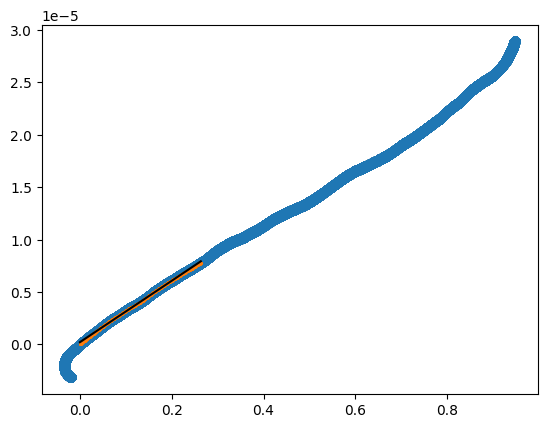

In [28]:
plt.scatter(temp_data_smooth, disp)
plt.scatter(x, y, s=.1)
plt.plot(x, outT[1] + x * outT[0], "k")

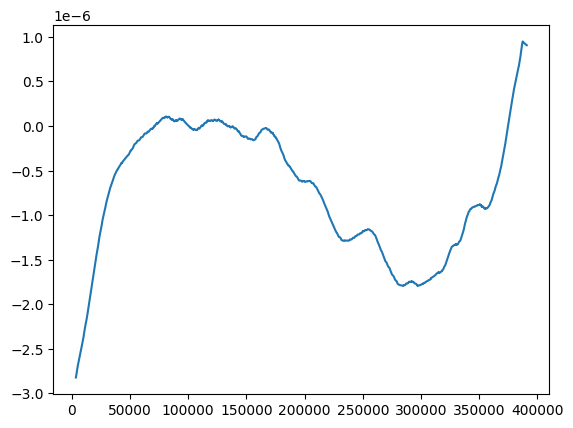

In [29]:
plt.plot(fsr['disp_detrend_temp'])

0.22393567259856548 -0.34739682422898677


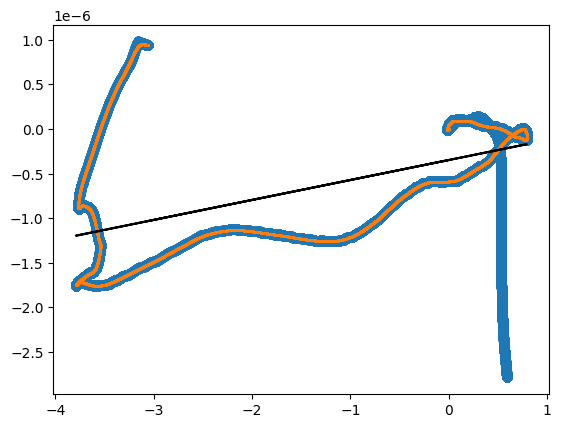

In [30]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from scipy.signal import detrend 

N1, N2 = 100_000, -1

# prepare temperature
baro = ffbi.copy().select(channel="*O")[0]
x_data = baro.data

# time temp
x_time = baro.times(reftime=fsr.time_utc.iloc[0])

# interpolate temp data
x_data = np.interp(fsr.time_sec, x_time, x_data)

# prepare displacment data
disp = __interpolate_nan(fsr.disp_detrend_temp.values)
y_data = disp

# smooth
y_data = __smooth(y_data, 7200, setpad=True)
x_data = __smooth(x_data, 24*3600, setpad=True)

baro_data_smooth = x_data

# trim
x_data = x_data[N1:N2]
y_data = y_data[N1:N2]

# reduce
x_data = __reduce(x_data, 10)
y_data = __reduce(y_data, 10)

# linear rtemp_data_smoothegression
x, y = x_data, y_data

# linear regression
outB = __compute_orthogonal_distance_regression(x, y)

# reduce temp data
baro_data_smooth -= np.nanmean(baro_data_smooth[N1:N1+10])
disp -= np.nanmean(disp[N1:N1+10])

print(outB[0]*1e6, outB[1]*1e6)

fsr['disp_detrend_baro'] = disp - ( outB[0] * baro_data_smooth + outB[1] )

fsr['disp_as_baro'] = disp / outB[0]

plt.scatter(baro_data_smooth, disp)
plt.scatter(x, y, s=.1)
plt.plot(x, outB[1] + x * outB[0], "k")

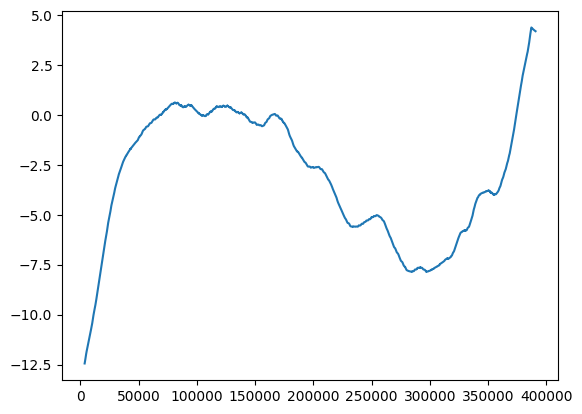

In [31]:
plt.plot(fsr['disp_as_baro'])

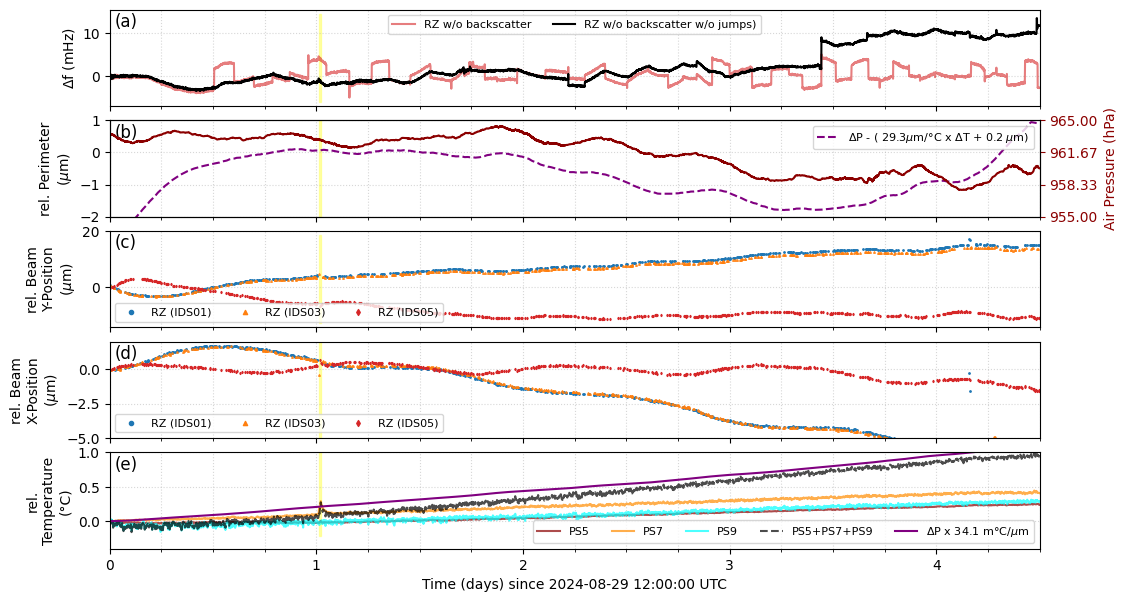

In [32]:
def __makeplot_fsr():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from functions.reduce import __reduce
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    reftime = config['tbeg']

    tscale, tunit = 1/86400, "days"

    fsrscale, fsrunit = 1e6, "$\mu$m"

    fscale, funit = 1e3, "mHz"

    Ncol, Nrow = 1, 5

    font = 10

    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(Nrow, Ncol, figsize=(12, 7), sharex=True)

    plt.subplots_adjust(hspace=0.15)

    # __________________________________________________________________________________________________

    ax0.plot((bs.time1 - reftime)*tscale, __reduce(bs.fj_bs*fscale, 60), color="tab:red", label="RZ w/o backscatter", alpha=0.6)
    ax0.ticklabel_format(useOffset=False)
    ax0.plot((bs.time1 - reftime)*tscale, __reduce(bs.fj_bs_dejump*fscale, 60), color="k", label="RZ w/o backscatter w/o jumps)")
    ax0.ticklabel_format(useOffset=False)
    # ax0.set_ylim(top=25)

    # __________________________________________________________________________________________________

    lbl = f"$\Delta$P - ( {round(outT[0]*1e6, 1)}$\mu$m/°C x $\Delta$T + {round(outT[1]*1e6, 1)} $\mu$m)"
    ax1.plot((fsr.time_utc - reftime)*tscale, fsr.disp_detrend_temp*fsrscale,
             color="purple", label=lbl, ls="--")
    ax1.set_ylim(-2, 1)

    # __________________________________________________________________________________________________

    ax111 = ax1.twinx()
    ax111.plot(ffbi.select(channel="*O")[0].times(reftime=reftime)*tscale,
               ffbi.select(channel="*O")[0].data, color="darkred"
              )
    # ax111.plot(stx.select(channel="*O")[0].times(reftime=reftime)*tscale,
    #            stx.select(channel="*O")[0].data, color="darkred", ls="--"
    #           )
    ax111.tick_params(axis='y', colors="darkred")
    ax111.set_ylabel("Air Pressure (hPa)", color="darkred")
    ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax1.get_yticks())))
    ax111.set_yticks(np.linspace(ax111.get_yticks()[0], ax111.get_yticks()[-1], len(ax1.get_yticks())))

    # __________________________________________________________________________________________________

    ax2.scatter((df01.time_utc - reftime)*tscale, df01.y_um_rel, c="tab:blue",
                s=1, zorder=2, label="RZ (IDS01)", marker="o")
    ax2.scatter((df03.time_utc - reftime)*tscale, df03.y_um_rel, c="tab:orange",
                s=1, zorder=2, label="RZ (IDS03)", marker="^")
    ax2.scatter((df05.time_utc - reftime)*tscale, df05.y_um_rel, c="tab:red",
                s=1, zorder=2, label="RZ (IDS05)", marker="d")

    # __________________________________________________________________________________________________

    ax3.scatter((df01.time_utc - reftime)*tscale, df01.x_um_rel, c="tab:blue",
                s=1, zorder=2, label="RZ (IDS01)", marker="o")
    ax3.scatter((df03.time_utc - reftime)*tscale, df03.x_um_rel, c="tab:orange",
                s=1, zorder=2, label="RZ (IDS03)", marker="^")
    ax3.scatter((df05.time_utc - reftime)*tscale, df05.x_um_rel, c="tab:red",
                s=1, zorder=2, label="RZ (IDS05)", marker="d")

    # __________________________________________________________________________________________________

    for tr in ps.select(channel="*KI"):
        num = int(tr.stats.location[-1])
        if num not in [1, 3]:
            _dat = __smooth(tr.data, 300, setpad=True)
            _dat = __reduce(_dat, 10)
            ax4.plot(tr.times(reftime=reftime)*tscale, _dat,
                     color=config['colors'][num], label=f"PS{num}", alpha=0.7)
            if num in [5, 7, 9]:
                if num == 5:
                    temp_sum = _dat
                else:
                    temp_sum += _dat

    ax4.plot(tr.times(reftime=reftime)*tscale, temp_sum,
             color="k", ls="--", label=f"PS5+PS7+PS9", alpha=0.7)

    # ax4.set_ylim(-0.5, 2.2)

    ax4.plot((fsr.time_utc - reftime)*tscale, __reduce(fsr.disp_as_temp, 10),
             color="purple", label=f"$\Delta$P x {round(1/(outT[0]*1e3), 1)} m°C/$\mu$m")

    # __________________________________________________________________________________________________

    # ax444 = ax4.twinx()
    # ax444.plot((fsr.time_utc - reftime)*tscale, __reduce(fsr.disp_rel*fsrscale, 10),
    #            color="purple", label=f"$\Delta$P - linear detrend")
    # ax444.tick_params(axis='y', colors="purple")
    # ax444.set_ylabel("rel. Perimeter ($\mu$m)", color="purple")
    # # ax4.set_yticks(np.linspace(ax4.get_yticks()[0], ax4.get_yticks()[-1], len(ax4.get_yticks())))
    # # ax444.set_yticks(np.linspace(ax444.get_yticks()[0], ax444.get_yticks()[-1], len(ax4.get_yticks())))

    # __________________________________________________

    ax4.set_xlabel(f"Time ({tunit}) since {str(config['tbeg'].date)[:10]} {str(config['tbeg'].time)[:10]} UTC", fontsize=font)

    # ax1.yaxis.set_minor_locator(MultipleLocator(10))
    # ax2.yaxis.set_minor_locator(MultipleLocator(12.5))
    # ax3.yaxis.set_minor_locator(MultipleLocator(10))

    for ax in [ax0, ax1, ax2, ax3]:
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(.25))

    for _k, (ax, ll) in enumerate(zip([ax0, ax1, ax2, ax3, ax4], ['(a)', '(b)', '(c)', '(d)', '(e)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    for ax in [ax0, ax1, ax2, ax3, ax4]:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")
        ax.set_xlim(0, (config['tend']-config['tbeg'])*tscale)

        # get limits
        _, _ , _ymin, _ymax = ax.axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = (lx1-UTCDateTime(reftime))*tscale
            lx2_sec = (lx2-UTCDateTime(reftime))*tscale
            ax.fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # for ax in [ax0, ax1, ax2, ax3]:
    #     ax.set_xticklabels([])

    ax0.legend(loc=9, ncol=3, fontsize=font-2, markerscale=3)
    ax1.legend(loc=1, ncol=1, fontsize=font-2, markerscale=3)
    ax2.legend(loc=3, ncol=3, fontsize=font-2, markerscale=3)
    ax3.legend(loc=3, ncol=3, fontsize=font-2, markerscale=3)
    ax4.legend(loc=4, ncol=5, fontsize=font-2, markerscale=3)

    ax3.set_ylim(-5, 2)
    ax4.set_ylim(-.4, 1.0)

    ax0.set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax1.set_ylabel(f"rel. Perimeter\n({fsrunit})", fontsize=font)
    ax2.set_ylabel(f"rel. Beam\nY-Position\n($\mu$m)", fontsize=font)
    ax3.set_ylabel(f"rel. Beam\nX-Position\n($\mu$m)", fontsize=font)
    ax4.set_ylabel(f"rel.\nTemperature\n(°C)", fontsize=font)

    # add title
    # ax0.set_title(f"Beam Wander - Horizontal Ring [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot_fsr()

fig.savefig(config['path_to_figs']+f"FSR_RZ_{config['tbeg']}_{config['tend']}_gps.png",
            format="png", dpi=150, bbox_inches='tight')


In [33]:
from functions.get_stream import __get_stream
from functions.interpolate_nan import __interpolate_nan

2 Trace(s) in Stream:
XX.FSR..XXX    | 2024-08-29T12:00:00.739891Z - 2024-09-02T23:34:04.739891Z | 1.0 Hz, 387245 samples
BW.FFBI.30.LDO | 2024-08-29T12:00:00.005000Z - 2024-09-02T23:59:59.005000Z | 1.0 Hz, 388800 samples

2 Trace(s) in Stream:
XX.FSR..XXX    | 2024-08-29T12:00:00.739891Z - 2024-09-02T23:34:04.739891Z | 1.0 Hz, 387245 samples
BW.FFBI.30.LDO | 2024-08-29T12:00:00.005000Z - 2024-09-02T23:59:59.005000Z | 1.0 Hz, 388800 samples

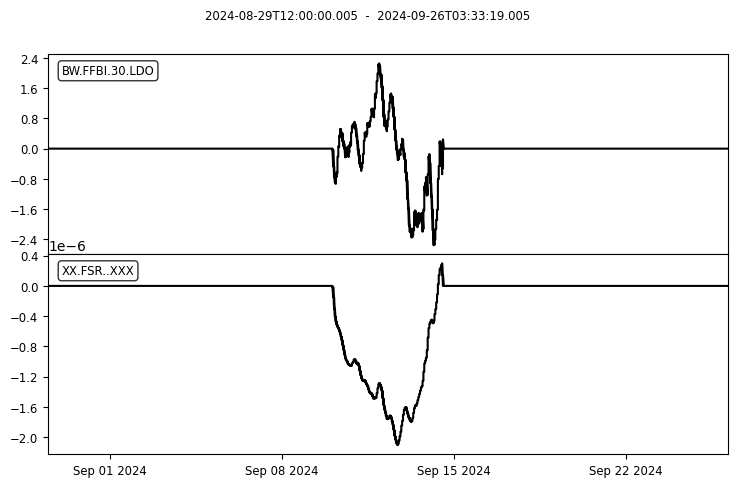

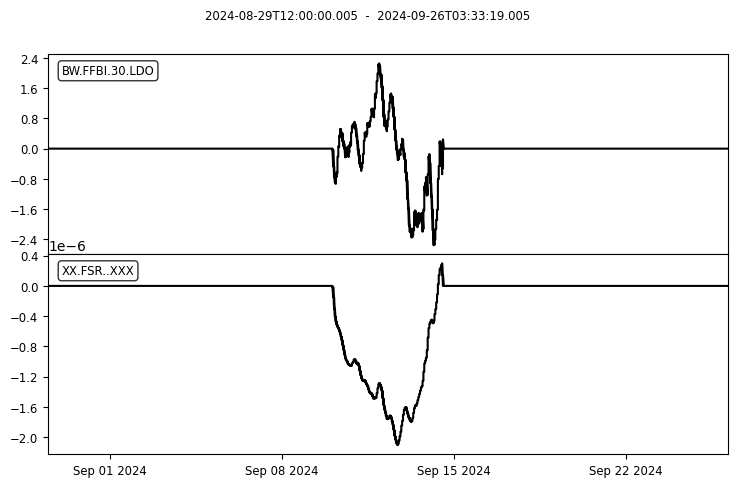

2 Trace(s) in Stream:
XX.FSR..XXX    | 2024-08-29T12:00:00.739891Z - 2024-09-26T03:07:24.739891Z | 1.0 Hz, 2387245 samples
BW.FFBI.30.LDO | 2024-08-29T12:00:00.005000Z - 2024-09-26T03:33:19.005000Z | 1.0 Hz, 2388800 samples

In [34]:
_dat = __interpolate_nan(fsr.disp_avg.values)

stx = __get_stream(_dat, 1.0, "XX.FSR..XXX", fsr.time_utc.iloc[0])
stx += ffbi.select(channel="*O").copy()

# stx.detrend("demean")
stx.detrend("linear")
stx.detrend("simple")

for tr in stx:
    tr.data = np.pad(tr.data, 1000_000, mode="edge")

stx.plot(equal_scale=False);

# stx.taper(0.01, type="cosine")

# stx.filter("bandpass", freqmin=1/(1*86400), freqmax=1/(1*3600), corners=2, zerophase=True)
stx.filter("highpass", freq=1/(1*86400), corners=2, zerophase=True)

for tr in stx:
    tr.data = tr.data[1000_000:-1000_000]



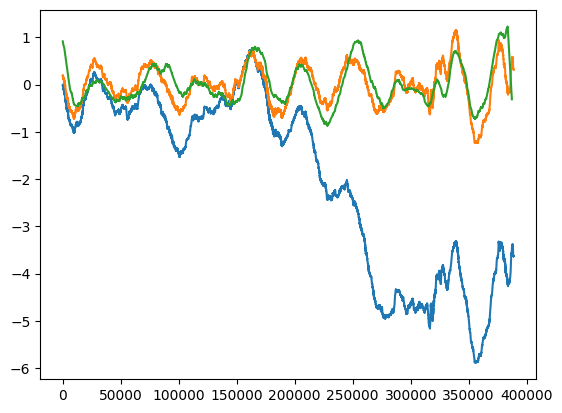

In [35]:
plt.plot(ffbi[1].times(), __reduce(ffbi[1].data, 10))
plt.plot(stx[1].times(), stx[1].data)
plt.plot(stx[0].times(), stx[0].data*5e6)

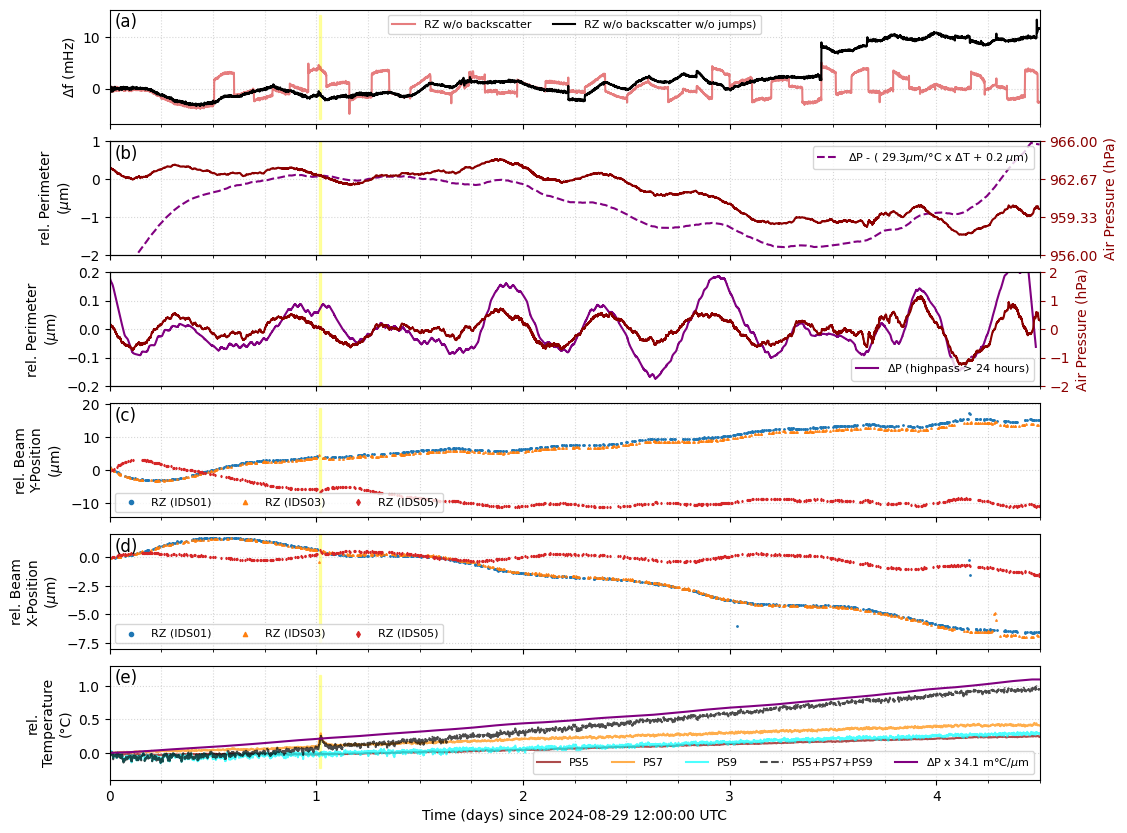

In [54]:
def __makeplot_fsr2():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from functions.reduce import __reduce
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    reftime = config['tbeg']

    tscale, tunit = 1/86400, "days"

    fsrscale, fsrunit = 1e6, "$\mu$m"

    fscale, funit = 1e3, "mHz"

    Ncol, Nrow = 1, 6

    font = 10

    fig, (ax0, ax1, ax5, ax2, ax3, ax4) = plt.subplots(Nrow, Ncol, figsize=(12, 10), sharex=True)

    plt.subplots_adjust(hspace=0.15)

    # __________________________________________________________________________________________________

    ax0.plot((bs.time1 - reftime)*tscale, __reduce(bs.fj_bs*fscale, 60), color="tab:red", label="RZ w/o backscatter", alpha=0.6)
    ax0.ticklabel_format(useOffset=False)
    ax0.plot((bs.time1 - reftime)*tscale, __reduce(bs.fj_bs_dejump*fscale, 60), color="k", label="RZ w/o backscatter w/o jumps)")
    ax0.ticklabel_format(useOffset=False)
    # ax0.set_ylim(top=25)

    # __________________________________________________________________________________________________

    ax5.plot(stx.select(station="FSR")[0].times(reftime=reftime)*tscale,
             stx.select(station="FSR")[0].data*fsrscale,
             color="purple", label=f"$\Delta$P (highpass > 24 hours)",
            )
    ax5.set_ylim(-.2, .2)

    # __________________________________________________

    ax555 = ax5.twinx()

    ax555.plot(stx.select(station="FFBI")[0].times(reftime=reftime)*tscale,
             stx.select(station="FFBI")[0].data,
             color="darkred", label=f"Pressure (highpass > 24 hours)",
            )

    ax555.tick_params(axis='y', colors="darkred")
    ax555.set_ylabel("Air Pressure (hPa)", color="darkred")
    ax5.set_yticks(np.linspace(ax5.get_yticks()[0], ax5.get_yticks()[-1], len(ax5.get_yticks())))
    ax555.set_yticks(np.linspace(ax555.get_yticks()[0], ax555.get_yticks()[-1], len(ax5.get_yticks())))

    # __________________________________________________________________________________________________

    lbl = f"$\Delta$P - ( {round(outT[0]*1e6, 1)}$\mu$m/°C x $\Delta$T + {round(outT[1]*1e6, 1)} $\mu$m)"
    ax1.plot((fsr.time_utc - reftime)*tscale, fsr.disp_detrend_temp*fsrscale,
             color="purple", label=lbl, ls="--")
    ax1.set_ylim(-2, 1)

    # __________________________________________________________________________________________________

    ax111 = ax1.twinx()
    ax111.plot(ffbi.select(channel="*O")[0].times(reftime=reftime)*tscale,
               ffbi.select(channel="*O")[0].data, color="darkred"
              )
    # ax111.plot(stx.select(channel="*O")[0].times(reftime=reftime)*tscale,
    #            stx.select(channel="*O")[0].data, color="darkred", ls="--"
    #           )
    ax111.tick_params(axis='y', colors="darkred")
    ax111.set_ylabel("Air Pressure (hPa)", color="darkred")
    ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax1.get_yticks())))
    ax111.set_yticks(np.linspace(ax111.get_yticks()[0], ax111.get_yticks()[-1], len(ax1.get_yticks())))

    # __________________________________________________________________________________________________

    ax2.scatter((df01.time_utc - reftime)*tscale, df01.y_um_rel, c="tab:blue",
                s=1, zorder=2, label="RZ (IDS01)", marker="o")
    ax2.scatter((df03.time_utc - reftime)*tscale, df03.y_um_rel, c="tab:orange",
                s=1, zorder=2, label="RZ (IDS03)", marker="^")
    ax2.scatter((df05.time_utc - reftime)*tscale, df05.y_um_rel, c="tab:red",
                s=1, zorder=2, label="RZ (IDS05)", marker="d")

    # __________________________________________________________________________________________________

    ax3.scatter((df01.time_utc - reftime)*tscale, df01.x_um_rel, c="tab:blue",
                s=1, zorder=2, label="RZ (IDS01)", marker="o")
    ax3.scatter((df03.time_utc - reftime)*tscale, df03.x_um_rel, c="tab:orange",
                s=1, zorder=2, label="RZ (IDS03)", marker="^")
    ax3.scatter((df05.time_utc - reftime)*tscale, df05.x_um_rel, c="tab:red",
                s=1, zorder=2, label="RZ (IDS05)", marker="d")

    # __________________________________________________________________________________________________

    for tr in ps.select(channel="*KI"):
        num = int(tr.stats.location[-1])
        if num not in [1, 3]:
            _dat = __smooth(tr.data, 300, setpad=True)
            _dat = __reduce(_dat, 10)
            ax4.plot(tr.times(reftime=reftime)*tscale, _dat,
                     color=config['colors'][num], label=f"PS{num}", alpha=0.7)
            if num in [5, 7, 9]:
                if num == 5:
                    temp_sum = _dat
                else:
                    temp_sum += _dat

    ax4.plot(tr.times(reftime=reftime)*tscale, temp_sum,
             color="k", ls="--", label=f"PS5+PS7+PS9", alpha=0.7)

    # ax4.set_ylim(-0.5, 2.2)

    ax4.plot((fsr.time_utc - reftime)*tscale, __reduce(fsr.disp_as_temp, 10),
             color="purple", label=f"$\Delta$P x {round(1/(outT[0]*1e3), 1)} m°C/$\mu$m")

    # __________________________________________________________________________________________________

    # ax444 = ax4.twinx()
    # ax444.plot((fsr.time_utc - reftime)*tscale, __reduce(fsr.disp_rel*fsrscale, 10),
    #            color="purple", label=f"$\Delta$P - linear detrend")
    # ax444.tick_params(axis='y', colors="purple")
    # ax444.set_ylabel("rel. Perimeter ($\mu$m)", color="purple")
    # # ax4.set_yticks(np.linspace(ax4.get_yticks()[0], ax4.get_yticks()[-1], len(ax4.get_yticks())))
    # # ax444.set_yticks(np.linspace(ax444.get_yticks()[0], ax444.get_yticks()[-1], len(ax4.get_yticks())))

    # __________________________________________________

    ax4.set_xlabel(f"Time ({tunit}) since {str(config['tbeg'].date)[:10]} {str(config['tbeg'].time)[:10]} UTC", fontsize=font)

    # ax1.yaxis.set_minor_locator(MultipleLocator(10))
    # ax2.yaxis.set_minor_locator(MultipleLocator(12.5))
    # ax3.yaxis.set_minor_locator(MultipleLocator(10))

    for ax in [ax0, ax1, ax2, ax3, ax5]:
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(.25))

    for _k, (ax, ll) in enumerate(zip([ax0, ax1, ax2, ax3, ax4], ['(a)', '(b)', '(c)', '(d)', '(e)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    for ax in [ax0, ax1, ax2, ax3, ax4, ax5]:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")
        ax.set_xlim(0, (config['tend']-config['tbeg'])*tscale)

        # get limits
        _, _ , _ymin, _ymax = ax.axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = (lx1-UTCDateTime(reftime))*tscale
            lx2_sec = (lx2-UTCDateTime(reftime))*tscale
            ax.fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # for ax in [ax0, ax1, ax2, ax3]:
    #     ax.set_xticklabels([])

    ax0.legend(loc=9, ncol=3, fontsize=font-2, markerscale=3)
    ax1.legend(loc=1, ncol=1, fontsize=font-2, markerscale=3)
    ax2.legend(loc=3, ncol=3, fontsize=font-2, markerscale=3)
    ax3.legend(loc=3, ncol=3, fontsize=font-2, markerscale=3)
    ax4.legend(loc=4, ncol=5, fontsize=font-2, markerscale=3)
    ax5.legend(loc=4, ncol=5, fontsize=font-2, markerscale=3)

    ax3.set_ylim(-8, 2)
    ax4.set_ylim(-.4, 1.3)

    ax0.set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax1.set_ylabel(f"rel. Perimeter\n({fsrunit})", fontsize=font)
    ax2.set_ylabel(f"rel. Beam\nY-Position\n($\mu$m)", fontsize=font)
    ax3.set_ylabel(f"rel. Beam\nX-Position\n($\mu$m)", fontsize=font)
    ax4.set_ylabel(f"rel.\nTemperature\n(°C)", fontsize=font)
    ax5.set_ylabel(f"rel. Perimeter\n({fsrunit})", fontsize=font)

    # add title
    # ax0.set_title(f"Beam Wander - Horizontal Ring [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot_fsr2()

fig.savefig(config['path_to_figs']+f"FSR_RZ_{config['tbeg']}_{config['tend']}_gps.png",
            format="png", dpi=150, bbox_inches='tight')


In [37]:
df = DataFrame()

N1 = 100_000

dt = 15*60

df['time_utc'] = fsr.time_utc[N1::dt]

df['time_utc_sec'] = [_t - df.time_utc.iloc[0] for _t in df.time_utc]

df['disp'] = fsr.disp_avg[N1::dt]

df['disp_um'] = df.disp*1e6

df['x_01'] = np.interp(df.time_utc_sec, df01.time_utc - UTCDateTime(df.time_utc.iloc[0]), df01.x_um_rel)
df['y_01'] = np.interp(df.time_utc_sec, df01.time_utc - UTCDateTime(df.time_utc.iloc[0]), df01.y_um_rel)
df['a_01'] = np.sqrt(df.x_01**2 + df.y_01**2)

df['x_03'] = np.interp(df.time_utc_sec, df03.time_utc - UTCDateTime(df.time_utc.iloc[0]), df03.x_um_rel)
df['y_03'] = np.interp(df.time_utc_sec, df03.time_utc - UTCDateTime(df.time_utc.iloc[0]), df03.y_um_rel)
df['a_03'] = np.sqrt(df.x_03**2 + df.y_03**2)

df['x_05'] = np.interp(df.time_utc_sec, df05.time_utc - UTCDateTime(df.time_utc.iloc[0]), df05.x_um_rel)
df['y_05'] = np.interp(df.time_utc_sec, df05.time_utc - UTCDateTime(df.time_utc.iloc[0]), df05.y_um_rel)
df['a_05'] = np.sqrt(df.x_05**2 + df.y_05**2)

df['baro'] = np.interp(df.time_utc_sec, ffbi[1].times(reftime=df.time_utc.iloc[0]), ffbi[1].data)

df['baro_sth'] = __smooth(df.baro, 60)

temp = ps.select(location="05")[0].data + ps.select(location="07")[0].data + ps.select(location="09")[0].data
df['temp'] = np.interp(df.time_utc_sec, ps[0].times(reftime=df.time_utc.iloc[0]), temp)

df['temp_sth'] = __smooth(df.temp, 60)

df = df.dropna()

In [38]:
for k in df.keys():
    if k not in ["time_utc"]:
        df[k+"_rel"] = __reduce(df[k].values, 10)

In [39]:
df

,time_utc,time_utc_sec,disp,disp_um,x_01,y_01,a_01,x_03,y_03,a_03,...,x_03_rel,y_03_rel,a_03_rel,x_05_rel,y_05_rel,a_05_rel,baro_rel,baro_sth_rel,temp_rel,temp_sth_rel
103586,2024-08-30T15:53:21.632275Z,0.000000,33.550963,3.355096e+07,0.120636,4.303879,4.305570,0.266713,3.711830,3.721400,...,0.023161,-0.286887,-0.284812,0.007511,0.490536,-0.487772,-0.167011,-0.113008,0.042408,0.003789
104486,2024-08-30T16:08:25.232646Z,903.600371,33.550963,3.355096e+07,0.107092,4.307243,4.308574,0.233893,3.756917,3.764191,...,-0.009660,-0.241800,-0.242021,0.013900,0.415239,-0.412213,-0.135794,-0.090566,0.014626,0.002650
105386,2024-08-30T16:23:28.823923Z,1807.191648,33.550963,3.355096e+07,0.099828,4.375116,4.376255,0.220453,3.884055,3.890307,...,-0.023099,-0.114662,-0.115905,0.028928,0.277639,-0.273800,-0.105559,-0.066937,-0.029410,0.001593
106286,2024-08-30T16:38:32.394738Z,2710.762463,33.550963,3.355096e+07,0.092565,4.442988,4.443952,0.214330,3.994027,3.999774,...,-0.029222,-0.004690,-0.006438,0.016460,0.163406,-0.161353,-0.095564,-0.042214,0.010161,0.000635
107186,2024-08-30T16:53:35.979581Z,3614.347306,33.550963,3.355096e+07,0.089614,4.547233,4.548116,0.191434,4.009398,4.013966,...,-0.052119,0.010681,0.007754,0.017203,0.115512,-0.113609,-0.037666,-0.016503,-0.008331,-0.000207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383486,2024-09-02T21:57:06.473879Z,281024.841604,33.550988,3.355099e+07,-6.550938,14.829139,16.211667,-6.968508,13.603833,15.284776,...,-7.212060,9.605115,11.278564,-1.840066,-5.111018,5.170345,-2.481196,-2.743405,0.801530,0.789363
384386,2024-09-02T22:12:10.116356Z,281928.484081,33.550988,3.355099e+07,-6.571761,14.978666,16.356909,-6.992965,13.738946,15.416232,...,-7.236518,9.740229,11.410020,-1.796510,-4.997066,5.051923,-2.700602,-2.708375,0.854751,0.789760
385286,2024-09-02T22:27:13.732630Z,282832.100355,33.550988,3.355099e+07,-6.587834,15.086437,16.462082,-6.993519,13.938102,15.594230,...,-7.237072,9.939385,11.588018,-1.767637,-4.864487,4.916833,-2.780573,-2.676495,0.799951,0.790072
386186,2024-09-02T22:42:17.349693Z,283735.717418,33.550988,3.355099e+07,-6.583319,15.213778,16.577067,-7.005709,13.924273,15.587345,...,-7.249261,9.925555,11.581133,-1.798217,-4.779808,4.836502,-2.892204,-2.647695,0.792020,0.790303


In [40]:
def __get_tides(tbeg, tend, component="N", typ="acc", df=3600):

    from pygtide import predict_series
    from numpy import arange, pi
    from obspy import UTCDateTime

    # ROMY
    lat = 48.162941
    lon = 11.275501
    height = 570

    startdate = str(UTCDateTime(tbeg).date)
    duration = (UTCDateTime(tend) - UTCDateTime(tbeg)) / 3600 # in hours
    sampling_rate = df # in seconds

    # creat time vector
    times = arange(0, duration+df/3600, df/3600)

    # prepare arguments
    args = (lat, lon, height, startdate, duration, sampling_rate)

    # specify station azimuth clockwise from north (=0)
    if component == "N":
        statazimut = 0
    elif component == "E":
        statazimut = 90

    if typ == "rad":
        # tides /= 9.81
        tides = predict_series(*args, statgravit=0, statazimut=statazimut, tidalcompo=1) # tilt

        # from mas to rad
        tides = tides * pi / 648000000

    elif typ == "acc":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=0) # horizontal acceleration

        # from nano to acc
        tides *= 1e-9

    elif typ == "str":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=5) # horizontal strain

        # from nano to str
        tides *= 1e-9

    return times, tides

In [41]:
t1, t2 = UTCDateTime(df.time_utc.iloc[0]).date, (UTCDateTime(df.time_utc.iloc[df.shape[0]-1])+86400).date

# predict tidal tilts
timesN1, tideN1 = __get_tides(t1, t2, component="N", typ="rad", df=3600)
timesE1, tideE1 = __get_tides(t1, t2, component="E", typ="rad", df=3600)

# predict horizontal strain
timesN3, tideN3 = __get_tides(t1, t2, component="N", typ="str", df=1800)
timesE3, tideE3 = __get_tides(t1, t2, component="E", typ="str", df=1800)

_tr = Trace()
_tr.data = tideE3
_tr.stats.delta = 1800
_tr.stats.starttime = UTCDateTime(t1)

_t1, _t2 = UTCDateTime(df.time_utc.iloc[0]), UTCDateTime(df.time_utc.iloc[df.shape[0]-1])
_tr = _tr.trim(_t1, _t2)

# add to frame
df['tideE'] = np.interp(df.time_utc_sec, _tr.times(reftime=_t1), _tr.data)

# tideNE = np.cos(np.deg2rad(30))*tideN3 + np.sin(np.deg2rad(30))*tideE3

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/pygtide/core.py:348: UserWarning: Please consider updating the leap second database 'b'etddt.dat        '' (last value is from 2017-01-01 00:00:00).
  warn("Please consider updating the leap second database '%s' (last value is from %s)." % (fname, self.etddt_end))
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/pygtide/core.py:352: UserWarning: Dates exceed permissible range for pole/LOD tide correction (interval 1962-01-01 00:00:00 to 2023-06-10 00:00:00). Consider update file 'b'etddt.dat        ''.
  warn("Dates exceed permissible range for pole/LOD tide correction (interval %s to %s). Consider update file '%s'." % (self.etpolut1_start, self.etpolut1_end, fname))


360.0

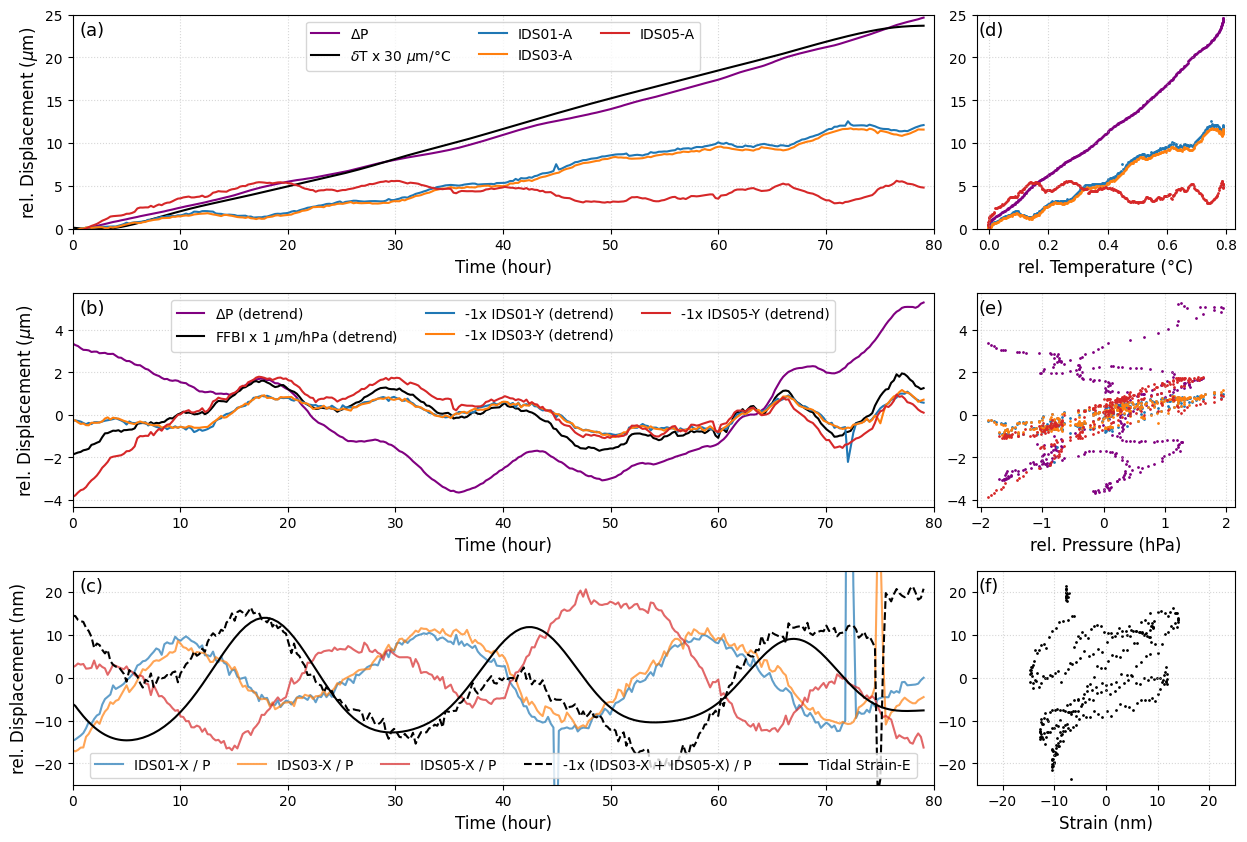

In [59]:
def __makeplot():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from scipy.signal import detrend

    # ___________________________________________

    tscale, tunit = 1/3600, "hour"

    Ncol, Nrow = 8, 3

    font = 12

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.3, wspace=0.4)

    ax10 = fig.add_subplot(gs1[0, :6])
    ax11 = fig.add_subplot(gs1[0, 6:])
    ax20 = fig.add_subplot(gs1[1, :6])
    ax21 = fig.add_subplot(gs1[1, 6:])
    ax30 = fig.add_subplot(gs1[2, :6])
    ax31 = fig.add_subplot(gs1[2, 6:])

    axes0 = [ax10, ax20, ax30]
    axes1 = [ax11, ax21, ax31]

    # ___________________________________________

    ax10.plot(df.time_utc_sec*tscale, df.disp_um_rel,
              color="purple", label="$\Delta$P")
    ax10.plot(df.time_utc_sec*tscale, df.temp_sth_rel*30,
              color='k', label="$\delta$T x 30 $\mu$m/°C")

    _fac = -3
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
    #           color="tab:blue", label=f"{_fac}x IDS01-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
    #           color="tab:orange", label=f"{_fac}x IDS03-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
    #           color="tab:red", label=f"{_fac}x IDS05-X")

#     ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_01_rel, s=1, color="tab:blue")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_03_rel, s=1, color="tab:orange")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_05_rel, s=1, color="tab:red")

    _fac = 1
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
              color="tab:blue", label= "IDS01-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
              color="tab:orange", label="IDS03-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
              color="tab:red", label="IDS05-A")

    ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_01_rel, s=1, color="tab:blue")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_03_rel, s=1, color="tab:orange")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_05_rel, s=1, color="tab:red")

    # ___________________________________________

    ax20.plot(df.time_utc_sec*tscale, detrend(df.disp_um_rel, type="linear") * 5,
              color="purple", label="$\Delta$P (detrend)")
    ax20.plot(df.time_utc_sec*tscale, detrend(df.baro_rel, type="linear"),
              color='k', label="FFBI x 1 $\mu$m/hPa (detrend)")
    ax20.plot(df.time_utc_sec*tscale, -detrend(df.y_01_rel, type="linear"),
              color="tab:blue", label="-1x IDS01-Y (detrend)")
    ax20.plot(df.time_utc_sec*tscale, -detrend(df.y_03_rel, type="linear"),
              color="tab:orange", label="-1x IDS03-Y (detrend)")
    ax20.plot(df.time_utc_sec*tscale, -detrend(df.y_05_rel, type="linear"),
              color="tab:red", label="-1x IDS05-Y (detrend)")

    ax21.scatter(detrend(df.baro_rel, type="linear"), detrend(df.disp_um_rel, type="linear") * 5,
                 s=1, color="purple")
    ax21.scatter(detrend(df.baro_rel, type="linear"), -detrend(df.y_01_rel, type="linear"),
                 s=1, color="tab:blue")
    ax21.scatter(detrend(df.baro_rel, type="linear"), -detrend(df.y_03_rel, type="linear"),
                 s=1, color="tab:orange")
    ax21.scatter(detrend(df.baro_rel, type="linear"), -detrend(df.y_05_rel, type="linear"),
                 s=1, color="tab:red")

    # ___________________________________________

    ax30.plot(df.time_utc_sec*tscale, detrend(df.x_01, type="linear")/33.5*1e3,
              color="tab:blue", label="IDS01-X / P", alpha=0.7)
    ax30.plot(df.time_utc_sec*tscale, detrend(df.x_03, type="linear")/33.5*1e3,
              color="tab:orange", label="IDS03-X / P", alpha=0.7)
    ax30.plot(df.time_utc_sec*tscale, detrend(df.x_05, type="linear")/33.5*1e3,
              color="tab:red", label="IDS05-X / P", alpha=0.7)

    x_sum = detrend(df.x_03, type="linear")+detrend(df.x_05, type="linear")
    ax30.plot(df.time_utc_sec*tscale, -x_sum/33.5*1e3,
              color="k", ls="--", label="-1x (IDS03-X + IDS05-X) / P")

    ax30.plot(df.time_utc_sec*tscale, df.tideE*1e9, color='k', label="Tidal Strain-E")

    # ax31.scatter(df.tideE*1e9, detrend(df.x_01, type="linear")/33.5*1e3,
    #              s=1, color="tab:blue")
    # ax31.scatter(df.tideE*1e9, detrend(df.x_03, type="linear")/33.5*1e3,
    #              s=1, color="tab:orange")
    # ax31.scatter( f.tideE*1e9, detrend(df.x_05, type="linear")/33.5*1e3,
    #              s=1, color="tab:red")

    ax31.scatter(df.tideE*1e9, -x_sum/33.5*1e3,
                 s=1, color="k")

    ax10.set_ylim(0, 25)
    ax11.set_ylim(0, 25)

    ax30.set_ylim(-25, 25)
    ax31.set_ylim(-25, 25)
    ax31.set_xlim(-25, 25)

    for _k, (ll, ax) in enumerate(zip(['(a)','(b)','(c)','(d)','(e)','(f)'], axes0+axes1)):
        ax.text(0.008, 0.97, ll, ha="left", va="top", transform=ax.transAxes, fontsize=font+1)

    for ax in axes0:
        ax.set_xlim(0, 80)
        ax.set_xlabel(f"Time ({tunit})", fontsize=font)
    for ax in axes0+axes1:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")

    ax10.legend(loc=9, ncol=3)
    ax20.legend(loc=9, ncol=3)
    ax30.legend(loc=8, ncol=5)

    ax10.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax20.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax30.set_ylabel(f"rel. Displacement (nm)", fontsize=font)

    ax11.set_xlabel(f"rel. Temperature (°C)", fontsize=font)
    ax21.set_xlabel(f"rel. Pressure (hPa)", fontsize=font)
    ax31.set_xlabel(f"Strain (nm)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot()

fig.savefig(config['path_to_figs']+f"FSR_RZ_{config['tbeg']}_{config['tend']}_gps_analysis.png",
            format="png", dpi=150, bbox_inches='tight')


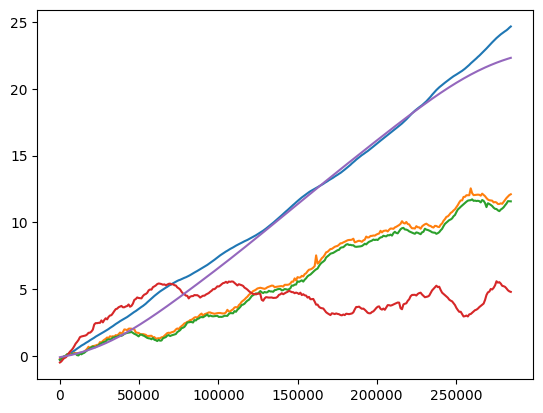

In [43]:
plt.plot(df.time_utc_sec, df.disp_um_rel)
plt.plot(df.time_utc_sec, df.a_01_rel)
plt.plot(df.time_utc_sec, df.a_03_rel)
plt.plot(df.time_utc_sec, df.a_05_rel)

plt.plot(df.time_utc_sec, __reduce(__smooth(df.temp_rel, 180), 10)*30)


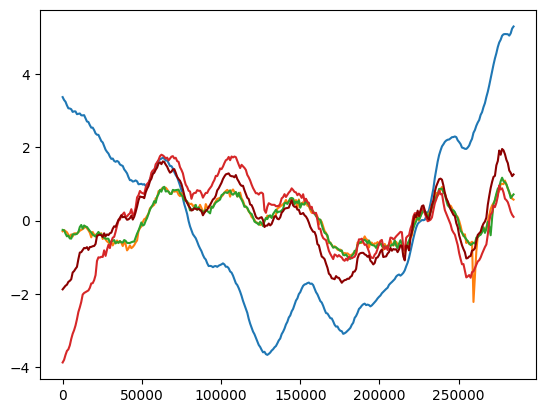

In [44]:
from scipy.signal import detrend

plt.plot(df.time_utc_sec, detrend(df.disp_um_rel, type="linear") * 5)
plt.plot(df.time_utc_sec, -detrend(df.y_01_rel, type="linear"))
plt.plot(df.time_utc_sec, -detrend(df.y_03_rel, type="linear"))
plt.plot(df.time_utc_sec, -detrend(df.y_05_rel, type="linear"))

plt.plot(df.time_utc_sec, detrend(df.baro_rel, type="linear"), 'darkred')

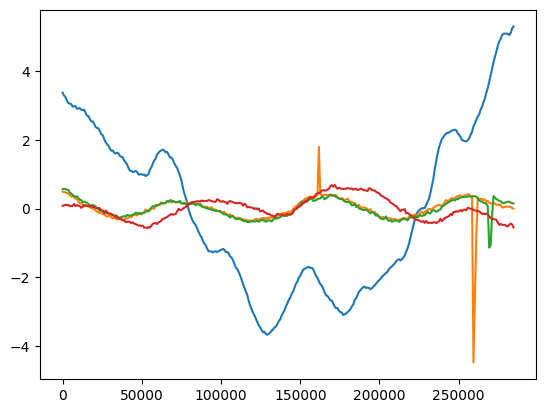

In [45]:
from scipy.signal import detrend

plt.plot(df.time_utc_sec, detrend(df.disp_um_rel, type="linear") * 5)
plt.plot(df.time_utc_sec, -detrend(df.x_01, type="linear"))
plt.plot(df.time_utc_sec, -detrend(df.x_03, type="linear"))
plt.plot(df.time_utc_sec, detrend(df.x_05, type="linear"))

# plt.plot(df.time_utc_sec, detrend(df.temp, type="linear"), 'darkred')

In [65]:
_tr = Trace()
_tr.data = tideN3
_tr.stats.delta = 1800
_tr.stats.starttime = UTCDateTime(t1)

_t1, _t2 = UTCDateTime(df.time_utc.iloc[0]), UTCDateTime(df.time_utc.iloc[df.shape[0]-1])
_tr = _tr.trim(_t1, _t2)

df['tideN'] = np.interp(df.time_utc_sec, _tr.times(reftime=_t1), _tr.data)

In [75]:
strain_um = ( 2*(np.cos(np.deg2rad(30))*df.tideN + np.sin(np.deg2rad(30))*df.tideE) + df.tideE ) *1e6

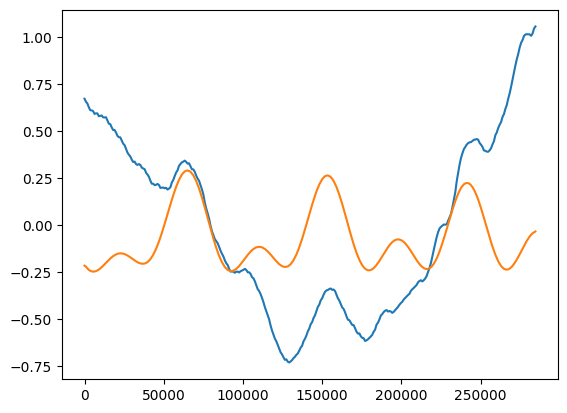

In [76]:
plt.plot(df.time_utc_sec, detrend(df.disp_um_rel, type="linear"))
# plt.plot(df.time_utc_sec, df.tideE*1e6)
plt.plot(df.time_utc_sec, strain_um*5)


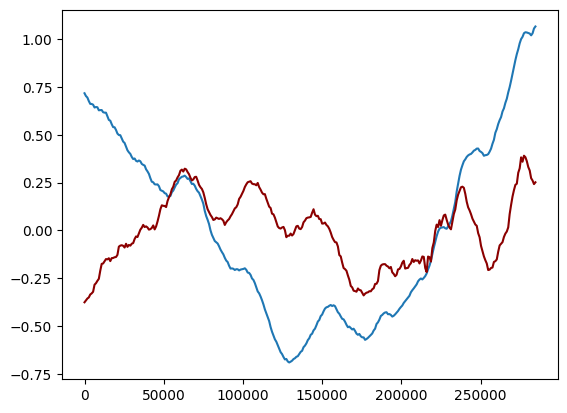

In [74]:
plt.plot(df.time_utc_sec, detrend(df.disp_um_rel, type="linear") - strain_um)
plt.plot(df.time_utc_sec, detrend(df.baro_rel, type="linear")*0.2, 'darkred')

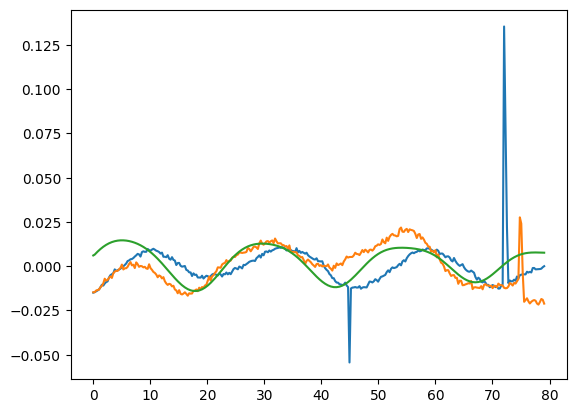

In [50]:
tscale = 1/3600

# plt.plot(df.time_utc_sec*tscale, detrend(df.disp_um_rel, type="linear")*33)

plt.plot(df.time_utc_sec*tscale, detrend(df.x_01, type="linear")/33)
# plt.plot(df.time_utc_sec*tscale, /33)
plt.plot(df.time_utc_sec*tscale, (detrend(df.x_05, type="linear")+detrend(df.x_03, type="linear"))/33)

plt.plot(df.time_utc_sec*tscale, -df.tideE*1e6)
